# Deriving Melbourne Land use from OSM

In [117]:
import osmnx as ox
import pandas as pd
import geopandas as gpd

<Axes: >

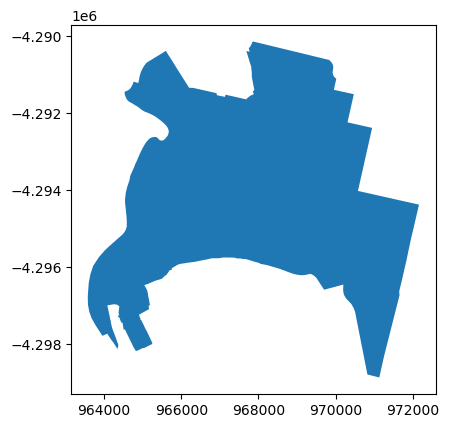

In [118]:
melbourne = 'City of Melbourne, Australia'

# Check boundary is correct
melb = ox.geocode_to_gdf(melbourne)
melb = melb.to_crs(epsg=3112)
melb.plot()

In [119]:
# Generate graph of all network
graph = ox.graph_from_place(melbourne, network_type="all")

In [120]:
# Defining borders for city blocks using OSM tags
# Roads: highway=motorway, trunk, primary, secondary, tertiary, residential, 
#        unclassified, motorway_link, trunk_link, primary_link, secondary_link, 
#        tertiary_link, living_street
# Railways: railway=*
# Waterways: waterway=*
# Buildings: building=*

In [121]:
# get waterways an railways as geometries
waterways = ox.features_from_place(melbourne, tags={'waterway': True})
railways = ox.features_from_place(melbourne, tags={'railway': True})

# Create a geodataframe from each, applying the meblourne CRS to the dataframes 
# (based on crs used in sentinel-1 method, EPSG:6283)
waterways_gdf = gpd.GeoDataFrame(waterways)
railways_gdf = gpd.GeoDataFrame(railways)

railways_gdf = railways_gdf.to_crs(epsg=3112)
waterways_gdf = waterways_gdf.to_crs(epsg=3112)

In [122]:
# Choosing road types from the highways tag in OSM to act as city block boundaries
network_tags = {'highway':['motorway','trunk',
                          'primary','secondary',
                          'tertiary','residential',
                          'unclassified','motorway_link',
                          'trunk_link','primary_link',
                          'secondary_link','tertiary_link',
                          'living_street']
                }

In [123]:
# deriving a geodataframe based on the roads specified in buffer function
roads = ox.features_from_place(melbourne, tags=network_tags)
roads_gdf = roads.to_crs(epsg=3112)

In [124]:
# I only want geometry types that are linestring for creating boundaries, so drop all other kinds

# Railways:
railways_gdf = railways_gdf[railways_gdf.geometry.type == 'LineString']

# Waterways:
waterways_gdf = waterways_gdf[waterways_gdf.geometry.type == 'LineString']

# Roads:
roads_gdf = roads_gdf[roads_gdf.geometry.type == 'LineString']


In [188]:
# Define a function to buffer line features with variable widths

# The buffer is being used to ensure that any unused space between the network and
# the land use is not being considered. eg. spaces directly next to railways are
# not going to be publicly accessible
def buffer_lines(lines_gdf):
    # Different buffer widths will be used dependning on the feature, chosen based on best guesses
    # buffer widths need to be adjusted to fit crs.
    buffer_widths = {
        'motorway':8,
        'trunk':5,
        'primary':5,
        'secondary':4,
        'tertiary':4,
        'residential':3,
        'unclassified':2,
        'motorway_link':8,
        'trunk_link':5,
        'primary_link':5,
        'secondary_link':4,
        'tertiary_link':4,
        'living_street':4
    }
    lines_gdf['buffered_geometry'] = lines_gdf.apply(
        lambda row: row['geometry'].buffer(buffer_widths.get(row['highway'], 0)), axis=1)
    return lines_gdf

In [189]:
roads_gdf = buffer_lines(roads_gdf)

<Axes: >

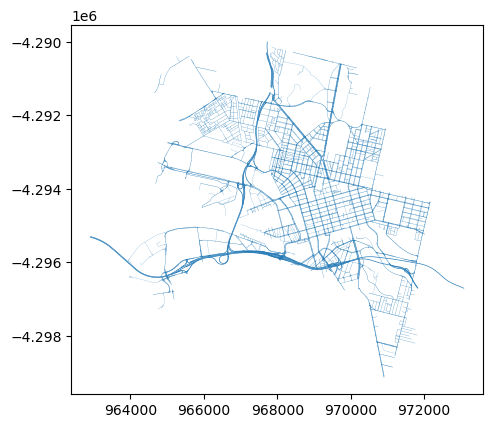

In [190]:
roads_gdf['buffered_geometry'].plot()

In [211]:
# For railways and waterways, no function needs to be defined
railways_gdf['buffered_geometry'] = railways_gdf.apply(lambda row: row['geometry'].buffer(5, 0), axis=1)
waterways_gdf['buffered_geometry'] = waterways_gdf.apply(lambda row: row['geometry'].buffer(10, 0), axis=1)

<Axes: >

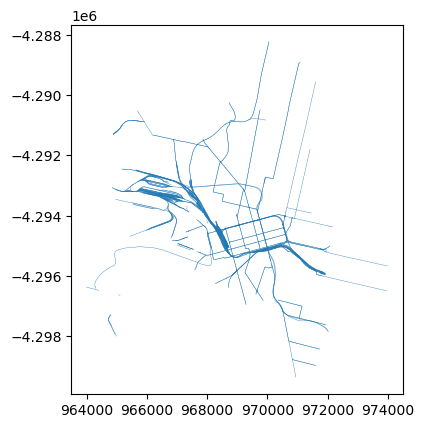

In [212]:
railways_gdf['buffered_geometry'].plot()

In [213]:
# Set crs of buffered geometry columns
roads_gdf['buffered_geometry'] = roads_gdf['buffered_geometry'].set_crs(epsg=3112)
railways_gdf['buffered_geometry'] = railways_gdf['buffered_geometry'].set_crs(epsg=3112)
waterways_gdf['buffered_geometry'] = waterways_gdf['buffered_geometry'].set_crs(epsg=3112)

In [214]:
# creating a dataframe of just buffered geometry
road_buffers = roads_gdf
road_buffers['geometry'] = road_buffers['buffered_geometry']
road_buffers = road_buffers.drop(columns='buffered_geometry')

# railways:
railway_buffers = railways_gdf
railway_buffers['geometry'] = railway_buffers['buffered_geometry']
railway_buffers = railway_buffers.drop(columns='buffered_geometry')

# waterways:
waterway_buffers = waterways_gdf
waterway_buffers['geometry'] = waterway_buffers['buffered_geometry']
waterway_buffers = waterway_buffers.drop(columns='buffered_geometry')

In [215]:

# Merge waterways and railways with the street network
merged_buffers = gpd.overlay(road_buffers, waterway_buffers, how='union')
merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')

/tmp/ipykernel_2513243/3885323959.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  merged_buffers = gpd.overlay(merged_buffers, railway_buffers, how='union')


<Axes: >

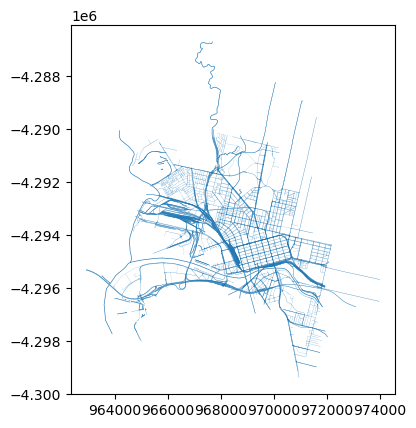

In [216]:
merged_buffers.plot()

In [217]:
# Generate city blocks by intersecting all features
# city_blocks = gpd.overlay(merged_buffers, merged_buffers, how='intersection')

In [218]:
# I want to clip the buffer dataframe to the boundary of melbourne
merged_buffers = gpd.clip(merged_buffers, melb)

<Axes: >

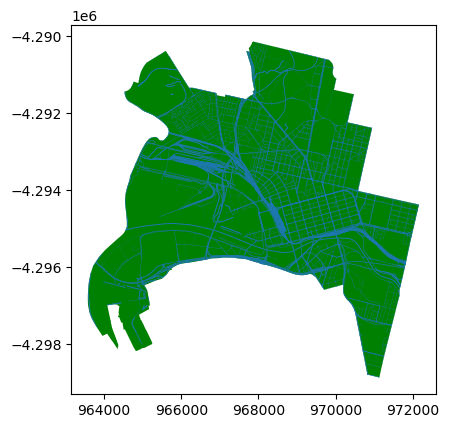

In [219]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
melb.plot(ax=ax, color='green')
merged_buffers.plot(ax=ax)

In [220]:
# using this, i can derive polygons shown in green using the difference function in gpd
# Calculate the difference between the city polygon and the road network
areas_with_no_roads = melb.difference(merged_buffers.unary_union)


In [221]:
city_blocks = areas_with_no_roads.explode(index_parts=True)

In [222]:
# create a geodataframe for these areas
city_blocks = gpd.GeoDataFrame(geometry=city_blocks, crs=melb.crs)

In [223]:
city_blocks = city_blocks.to_crs(epsg=3112)
city_blocks.crs

<Projected CRS: EPSG:3112>
Name: GDA94 / Geoscience Australia Lambert
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Australia - Australian Capital Territory; New South Wales; Northern Territory; Queensland; South Australia; Tasmania; Western Australia; Victoria.
- bounds: (112.85, -43.7, 153.69, -9.86)
Coordinate Operation:
- name: Geoscience Australia Standard National Scale Lambert Projection
- method: Lambert Conic Conformal (2SP)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [224]:
# Finding the area of each city block identified:
city_blocks['area'] = city_blocks['geometry'].area

We now know that is the largest region where greenspace is going to be found, provided none exists on roads. Tunnels have been excluded, as there is potential for green areas to be on the land above them.

In [233]:
# identify any city blocks with an area less than 10 metres
tiny_blocks = city_blocks[city_blocks['area'] < 10]
print('There are', len(tiny_blocks), 'city blocks less than 10m in Melbourne.')

There are 231 city blocks less than 10m in Melbourne.


## Tags from OSM associated with greenspace

In [236]:
greenspace_tags = {'landuse':['flowerbed','forest',
                              'greenhouse_horticulture',
                              'meadow','orchard',
                              'plant_nursery','vineyard',
                              'grass','greenfield','village_green'],
                   'leisure':['dog_park','garden','golf_course',
                              'nature_reserve','park','pitch']
                  }
                              

In [237]:
greenspace = ox.features_from_place(melbourne, tags=greenspace_tags)
greenspace_gdf = greenspace.to_crs(epsg=3112)
greenspace_gdf = greenspace_gdf[greenspace_gdf.geometry != 'Point']

## Adding building footprints to the map

For the most part, buildings are typically areas where there is no greenspace. however, things like rooftop and vertical gardens cannot be ruled out.

In [225]:
buildings = ox.features_from_place(melbourne, tags={'building':True})
buildings_gdf = buildings.to_crs(epsg=3112)

In [226]:
# removing points so only polygons are representing the footprints
buildings_gdf = buildings_gdf[buildings_gdf.geometry.type == 'Polygon']

## Finding Public Parks in Melbourne

In [227]:
# Locating all of the parks in Melbourne
parks = ox.features_from_place(melbourne, tags={'leisure':'park'})
parks_gdf = parks.to_crs(epsg=3112)

In [228]:
# showing only parks that are not private according to OSM. There are two locations that are tagged as private
public_parks_gdf = parks_gdf[parks_gdf['access'] != 'private']

/tmp/ipykernel_2513243/2256846407.py:20: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


Text(0.5, 1.0, 'Melbourne City')

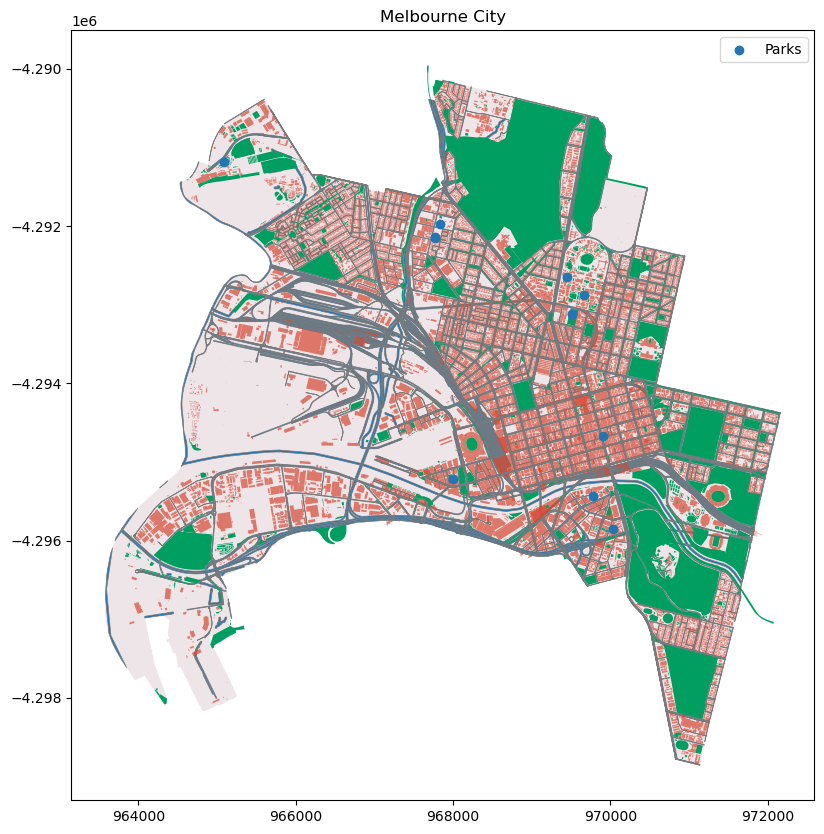

In [242]:
# Visualise in a single figure all the OSM data that was foud:
# Create a figure and an axis for plotting, and set the figure size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each of the GeoDataFrames on the plotting axis to ensure they are all on the same figure
# Plot the 'area' GeoDataFrame with black face color
melb.plot(ax=ax, facecolor="#EEE5E9")

# edges geodataframe
merged_buffers.plot(ax=ax, linewidth=0.5, edgecolor="#7C7C7C", label='City Block Boundaries')

# hospitals geodataframe
buildings_gdf.plot(ax=ax, facecolor="#D64933", alpha=0.7, label='Buildings')

# greenspace
greenspace_gdf.plot(ax=ax, facecolor='#009E60', label='Parks')

# private parks

plt.legend()
ax.set_title('Melbourne City')